# Multi-armed Bandit

O problema do bandido multi-armado (ou MAB) pode ser visto como um conjunto de distribuições reais associada às recompensas entregues por um dos $K \in \mathbb{N}^+$ braços: $B = \{ R_{1}, \dots, R_{K}\}$, onde $\{\mu_{1}, \dots, \mu_{K}\}$ são os valores médios associados a essas distribuições de recompensas.  
O jogador seleciona iterativamente uma alavanca por rodada e observa a recompensa associada.  
O objetivo é maximizar a soma das recompensas coletadas.


Este notebook utiliza a política _Softmax com annealing_ para selecionar o melhor braço.
Seleciona o braço de acordo com a probabilidade:

$Prob_j(t) = \frac{e^\frac{\widehat{\mu_j}(t)}{\tau(t)}}{\sum \limits_j e^\frac{\widehat{\mu_j}(t)}{\tau(t)}}
$ e $\tau(t) = \frac{\tau_0}{t+1}$

## Autor: h3dema

In [1]:
%matplotlib inline

# imports
from random import randint
import numpy as np
import matplotlib.pyplot as plt

from util import return_normal
from policies import softmax_annealing

In [2]:
# parametros de execução
K = 3  # braços
T = 1000  # numero de iterações

n = 3  # numero de iterações para montar a estimativa inicial das médias

In [7]:
# medias e variancias dos braços
arm_means = [2.67, 1.64, 1.99]
arm_variances = [0.5, 0.1, 0.5]

# baseado na distribuição normal, obtem as recompensas em cada braço
rewards = [return_normal(T + n, arm_means[i], variance=arm_variances[i]) for i in range(K)]

# usa os primeiros valores para calcular a estimativa inicial das médias para cada braço
means_k = []
for i in range(K):
    # média dos n primeiros valores para cada braço
    means_k.append(np.mean(rewards[i][:n]))
    # mantem somente as T recompensas seguintes
    rewards[i] = rewards[i][n:]

In [8]:
# mostra média real do melhor braço: que sabemos ser o 0
best_arm = rewards.index(max(rewards))
real_avg = np.mean(rewards[best_arm])
print "média do braço %d: %7.5f" % (best_arm, real_avg)

média do braço 0: 2.67778


In [9]:
# simple MAB algorithm
def run(K, T, rewards, method, verbose=False, **kwargs):
    """
    return:
        selected_arm:
            lista com os braços selecionados a cada instante
        r:
            recompensa obtida para cada seleção
    """
    num_selected_arm = [1 for i in range(K)]
    r = [-1 for i in range(T)]
    for i in range(T):
        arm = method.select_arm(means_k)

        r_t = rewards[arm][i]
        r[i] = r_t

        # update mean
        means_k[arm] = num_selected_arm[arm] * means_k[arm] + r_t
        num_selected_arm[arm] += 1
        means_k[arm] /= num_selected_arm[arm]
        if verbose:
            print 'Round', i, 'melhor braço:', arm, 'Recompensa:', r_t

    return method.selected_arm, r

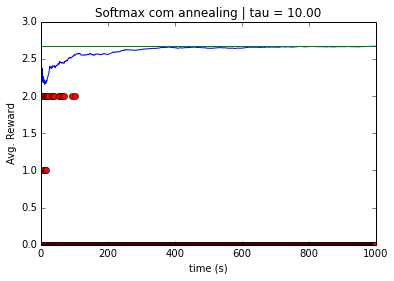

In [12]:
fig = 1
tau = 10.0
selected_arm, r = run(K, T, 
                      method=softmax_annealing(K, tau=tau),
                      rewards=rewards,
                      means_k=means_k)
r_mean = [np.mean(r[:i + 1]) for i in range(T)]
plt.figure(fig)
X = [i for i in range(T)]
plt.plot(X, r_mean, X, selected_arm, 'ro')
plt.plot([0, T], [real_avg, real_avg])
plt.ylabel('Média da recompensa')
plt.xlabel('Tempo (s)')
y_max = 0.9 * max(r_mean)
plt.title('Softmax com annealing | tau = %5.2f' % (tau))
fig += 1
